In [1]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from LabFuncs import *
from WIMPFuncs import *
from NeutrinoFuncs import *
from Params import *
from scipy.stats import norm
import cmocean
from Params import *


Nuc = F19
E_th = 5.0
E_max = 50.0
DM = WIMP(10.0,1.0e-45)
HaloModel = SHM
Loc = Boulby
NuBG = GetNuFluxes(0.0,Nuc)
E_nu_all = NuBG.Energy
Flux_all = NuBG.Flux
n_nu = NuBG.NumberOfNeutrinos 
Errs = NuBG.Uncertainties


#####

def GetMaps(t,ne,n):
    E_r_vals = linspace(E_th,E_max,ne)
    nn = int(n*n/2)
    PH, TH = meshgrid(linspace(0, 2*pi, n), linspace(-pi/2, pi/2, int(n/2)))
    X = cos(PH)*cos(TH)
    Y = -sin(PH)*cos(TH)
    Z = sin(TH)
    ii = 0
    q = zeros(shape=(nn,3))
    for i in range(0,int(n/2)):
        for j in range(0,n):
            q[ii,:] = array([X[i,j],Y[i,j],Z[i,j]])
            ii = ii+1

    def Get_q_lab(JD):
        lat = Loc.Latitude
        lon = Loc.Longitude
        UT = 24*(JD+0.5-floor(JD+0.5))
        MJD = JD - 2400000.5
        T_0 = (floor(MJD)-55197.5)/36525.0
        t_GAST = (101.0308 + 36000.770*T_0 + 15.04107*UT)/15.0
        t_lab = t_GAST + lon/15.0
        t_lab = 15*t_lab # DEGREES
        q_lab = zeros(shape=shape(q))
        for i in range(0,shape(q)[0]):
            q_lab[i,:] =  gal2lab(q[i,:],t_lab, lat)
        return q_lab

    def convertmap(R3D):
        R_map = zeros(shape=(int(n/2),n))
        ii = 0
        for i in range(0,int(n/2)):
            for j in range(0,n):
                R_map[i,j] = R3D[0,ii]
                ii = ii+1
        R_map = flipud(R_map)
        return R_map

    dR_wimp = zeros(shape=(1,int(n*n/2)))
    dR_nu = zeros(shape=(1,int(n*n/2)))
    q_lab = Get_q_lab(t)
    for i in range(0,ne):
        E = -1*E_r_vals[i]*q_lab
        dR_wimp = dR_wimp + dRdEdO_wimp(E,t*ones(shape=int(n*n/2)),DM,HaloModel,Nuc,Loc)  
        dR_nu = dR_nu + dRdEdO_solarnu(E,t*ones(shape=int(n*n/2)),E_nu_all[:,5],Flux_all[:,5],Nuc,Loc)
    dR_wimp = dR_wimp/amax(dR_wimp)
    dR_nu = dR_nu/amax(dR_nu)
    dR = (dR_wimp-dR_nu)

    dR_map = zeros(shape=(int(n/2),n))
    dR_mapw = zeros(shape=(int(n/2),n))
    dR_mapn = zeros(shape=(int(n/2),n))
    ii = 0
    for i in range(0,int(n/2)):
        for j in range(0,n):
            dR_map[i,j] = dR[0,ii]
            dR_mapw[i,j] = dR_wimp[0,ii]
            dR_mapn[i,j] = dR_nu[0,ii]
            ii = ii+1
    return PH,TH,dR_wimp,dR_mapw,dR_mapn

In [2]:
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.colors as colors


plt.rcParams['axes.linewidth'] = 3
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=15)

cmap = plt.get_cmap('Reds_r')
new_reds = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=0, b=0.9),
        cmap(linspace(0, 0.9, 10)))
new_reds.set_bad('black')


cmap = plt.get_cmap('Blues_r')
new_blues = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=0, b=0.9),
        cmap(linspace(0, 0.9, 10)))
new_blues.set_bad('black')


from astropy import units as u
from astropy.coordinates import SkyCoord, get_constellation

cygnus_stars = array(['β','η','γ','α','γ','δ','ι','κ','ι','δ','γ','ε','ζ'])
#cygnus_stars = ['Deneb','gamma cyg']
nst = size(cygnus_stars)
cyg = zeros(shape=(nst,2))
for i in range(0,nst):
    c = SkyCoord.from_name(cygnus_stars[i]+' Cyg').galactic
    cyg[i,:] = array([c.l.degree,c.b.degree])

Months = array(['January','February','March','April','May','June','July','August','September','October','November','December'])
datecumsum = cumsum(array([31,28,31,30,31,30,31,31,30,31,30,31]))




In [ ]:
def Psun(JD):
    lat = Loc.Latitude
    lon = Loc.Longitude
    UT = 24*(JD+0.5-floor(JD+0.5))
    MJD = JD - 2400000.5
    T_0 = (floor(MJD)-55197.5)/36525.0
    t_GAST = (101.0308 + 36000.770*T_0 + 15.04107*UT)/15.0
    t_lab = t_GAST + lon/15.0
    t_lab = 15*t_lab # DEGREES
    q_sun = lab2gal(SolarDirection(JD,Loc),t_lab,lat)
    return array([arctan2(-q_sun[1],q_sun[0]),arcsin(q_sun[2])])*180/pi

# ecliptic
ntt = 200
times = Jan1+linspace(0,364,ntt)
ecl = zeros(shape=(ntt,2))
for i in range(0,ntt):
    JD = times[i]
    ecl[i,:] = Psun(times[i])
ecl = ecl[argsort(ecl[:,0]),:]

ti = 0
PH,TH,dR_wimp,dR_mapw,dR_mapn = GetMaps(Jan1+ti,20,200)
cmax = 1.0
cmin = 0.0
#dR_mapn[dR_mapn<0.01] = nan
#dR_mapw[dR_mapw==0.0] = nan
    

cmap = cmocean.cm.deep_r
nlevels = 20
tfs = 35
gridlinecolor = 'w'


# Set up figure
fig, axarr = plt.subplots(1, 1,figsize=(20,10))
gs = gridspec.GridSpec(1, 1)
gs.update(wspace=0.1)

# Mollweide
#ax = plt.subplot(gs[0],projection=ccrs.Mollweide())
#xtx = array([0.17,0.05,-0.01,0.05,0.18])
#ytx = array([0.1,0.26,0.49,0.72,0.9])
#tx = array([r'$-60^\circ$',r'$-30^\circ$',r'$0^\circ$',r'$+30^\circ$',r'$+60^\circ$']) 

# PlateCarree
ax = plt.subplot(gs[0],projection=ccrs.PlateCarree())
xtx = array([-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01])
ytx = array([0.0,0.16,0.33,0.5,0.66,0.83,1.0])
tx = array([r'$-90^\circ$',r'$-60^\circ$',r'$-30^\circ$',r'$0^\circ$',r'$+30^\circ$',r'$+60^\circ$',r'$+90^\circ$']) 
xtx_l = array([0.0,0.16,0.33,0.5,0.66,0.83,1.0])
ytx_l = array([-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03])
tx_l = array([r'$180^\circ$',r'$120^\circ$',r'$60^\circ$',r'$0^\circ$',r'$300^\circ$',r'$240^\circ$',r'$180^\circ$']) 



# Axis lines
gl = ax.gridlines(color=gridlinecolor,linewidth=1.5, linestyle='--',alpha=0.5)
gl.ylocator = mticker.FixedLocator([-90,-60, -30, 0, 30, 60,90])
ax.outline_patch.set_linewidth(3)

for i in range(0,size(xtx)):
    plt.text(xtx[i],ytx[i],tx[i],transform=ax.transAxes,horizontalalignment='right',verticalalignment='center',fontsize=tfs)
    plt.text(xtx_l[i],ytx_l[i],tx_l[i],transform=ax.transAxes,horizontalalignment='center',verticalalignment='top',fontsize=tfs)

ax.plot(-cyg[0:4,0],cyg[0:4,1],'-',color='crimson',transform=ccrs.PlateCarree())
ax.plot(-cyg[4:,0],cyg[4:,1],'-',color='crimson',transform=ccrs.PlateCarree())
ax.plot(-cyg[:,0],cyg[:,1],'.',color='k',ms=10,transform=ccrs.PlateCarree())
ax.text(120,3,r'{\bf Galactic}',color=gridlinecolor,transform=ccrs.PlateCarree(),fontsize=tfs)
ax.text(128,-8,r'{\bf plane}',color=gridlinecolor,transform=ccrs.PlateCarree(),fontsize=tfs)
ax.plot(ecl[:,0],ecl[:,1],'-',lw=3,color='yellow',transform=ccrs.PlateCarree())
ax.text(-30,-20,r'{\bf Ecliptic}',color='yellow',transform=ccrs.PlateCarree(),fontsize=tfs,rotation=60)
ax.background_patch.set_facecolor('k')

ax.plot(Psun(Jan1+ti)[0],Psun(Jan1+ti)[1],'y*',ms=50,markerfacecolor='gold',mec='orangered',mew=2,transform=ccrs.PlateCarree())
ax.contourf(rad2deg(PH), rad2deg(TH), dR_mapw,levels=linspace(0.01,1.0,25),transform=ccrs.PlateCarree(),cmap=cmocean.cm.ice,vmin=cmin,vmax=cmax)
ax.contourf(rad2deg(PH), rad2deg(TH), dR_mapn,levels=linspace(0.01,1.0,25),transform=ccrs.PlateCarree(),cmap=cmocean.cm.solar,vmin=cmin,vmax=cmax,alpha=0.8,antialiased=True)
ax.text(0.3,-0.16,'Galactic longitude, $l$',transform=ax.transAxes,fontsize=tfs+10)
ax.text(-0.12,0.2,'Galactic latitude, $b$',transform=ax.transAxes,fontsize=tfs+10,rotation=90)

plt.gcf().text(0.8,0.8,r'C.~A.~J.~O\'Hare',fontsize=20,color='w',horizontal_alignment='right')
ax.plot([0,0],[-90,90],'.',color=gridlinecolor,transform=ccrs.PlateCarree())
ax.plot([-181,181],[0,0],'-',color=gridlinecolor,lw=1.5,transform=ccrs.PlateCarree())
imonth = arange(0,12)[datecumsum-ti>0][0]
wmonth = Months[imonth]
di = around(1+ti*(imonth==0)+(ti-datecumsum[imonth-1])*(imonth>0))
ax.set_title(r'{\bf '+wmonth+' '+str(int(di))+'}',fontsize=tfs+5,pad=15)
plt.show()

January 1 0.0
January 2 1.2166666666666666
January 3 2.433333333333333
January 5 3.6499999999999995
January 6 4.866666666666666
January 7 6.083333333333333
January 8 7.299999999999999
January 10 8.516666666666666
January 11 9.733333333333333
January 12 10.95
January 13 12.166666666666666
January 14 13.383333333333333
January 16 14.599999999999998
January 17 15.816666666666665
January 18 17.03333333333333
January 19 18.25
January 20 19.466666666666665
January 22 20.68333333333333
January 23 21.9
January 24 23.116666666666664
January 25 24.333333333333332
January 27 25.549999999999997
January 28 26.766666666666666
January 29 27.98333333333333
January 30 29.199999999999996
January 31 30.416666666666664
February 2 31.63333333333333
February 3 32.849999999999994
February 4 34.06666666666666
February 5 35.28333333333333
February 6 36.5
February 8 37.71666666666666
February 9 38.93333333333333
February 10 40.15
February 11 41.36666666666666
February 13 42.58333333333333
February 14 43.8
Febru

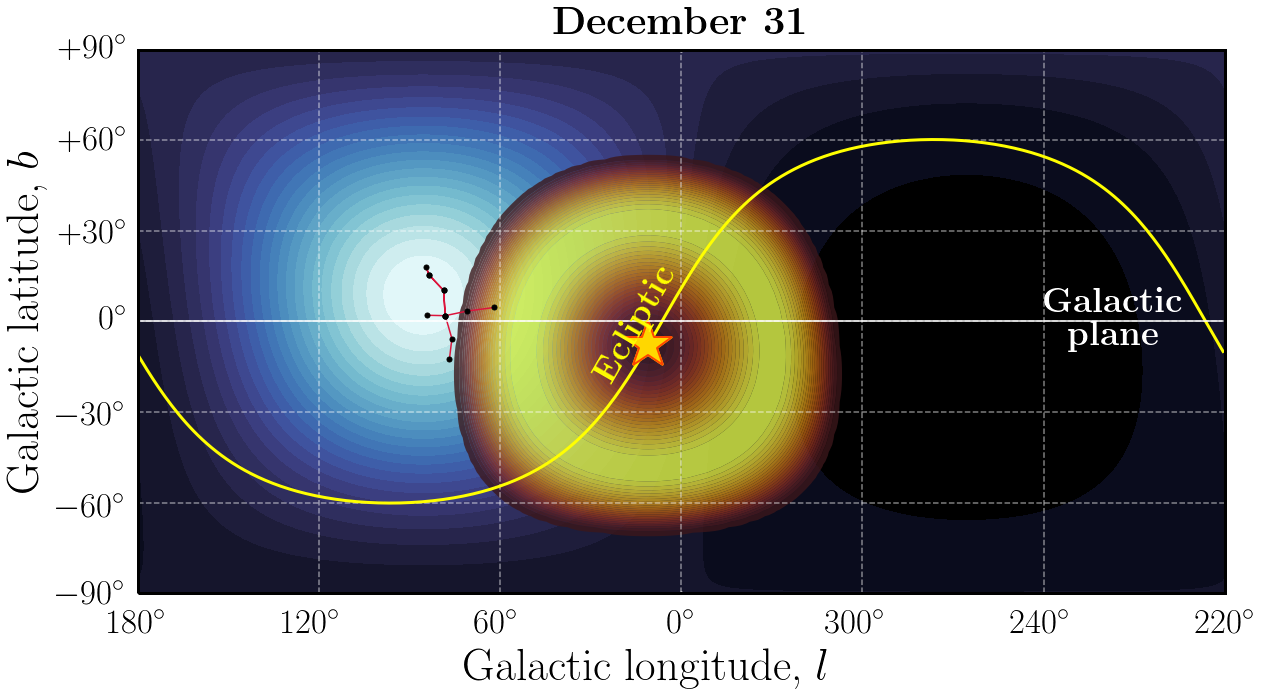

In [128]:
# %matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML

# Set up figure
fig, axarr = plt.subplots(1, 1,figsize=(20,10))
gs = gridspec.GridSpec(1, 1)
gs.update(wspace=0.1)
ax = plt.subplot(gs[0],projection=ccrs.PlateCarree())
xtx = array([-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01])
ytx = array([0.0,0.16,0.33,0.5,0.66,0.83,1.0])
tx = array([r'$-90^\circ$',r'$-60^\circ$',r'$-30^\circ$',r'$0^\circ$',r'$+30^\circ$',r'$+60^\circ$',r'$+90^\circ$']) 
xtx_l = array([0.0,0.16,0.33,0.5,0.66,0.83,1.0])
ytx_l = array([-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03])
tx_l = array([r'$180^\circ$',r'$120^\circ$',r'$60^\circ$',r'$0^\circ$',r'$300^\circ$',r'$240^\circ$',r'$220^\circ$']) 

def init(): 
    points = ax.plot(-cyg[:,0],cyg[:,1],'.',color='k',ms=10,transform=ccrs.PlateCarree())
    return points

frames = 300
interval = (365.0/(1.0*frames))

# animation function. This is called sequentially
def animate(i):
    ti = i*interval
    t = Jan1 + ti
    imonth = arange(0,12)[datecumsum-ti>0][0]
    wmonth = Months[imonth]
    di = int(around(1+ti*(imonth==0)+(ti-datecumsum[imonth-1])*(imonth>0)))
    print(wmonth,di,i*interval)
    
    
    
    PH,TH,dR_wimp,dR_mapw,dR_mapn = GetMaps(t,20,200)
    cmax = 1.0
    cmin = 0.0
    #dR_mapn[dR_mapn<0.01] = nan
    #dR_mapw[dR_mapw<0.01] = nan
    
    ax.clear()
    gl = ax.gridlines(color=gridlinecolor,linewidth=1.5, linestyle='--',alpha=0.5)
    gl.ylocator = mticker.FixedLocator([-90,-60, -30, 0, 30, 60,90])
    ax.outline_patch.set_linewidth(3)

    for j in range(0,size(xtx)):
        plt.text(xtx[j],ytx[j],tx[j],transform=ax.transAxes,horizontalalignment='right',verticalalignment='center',fontsize=tfs)
        plt.text(xtx_l[j],ytx_l[j],tx_l[j],transform=ax.transAxes,horizontalalignment='center',verticalalignment='top',fontsize=tfs)
    ax.text(0.3,-0.16,'Galactic longitude, $l$',transform=ax.transAxes,fontsize=tfs+10)
    ax.text(-0.12,0.2,'Galactic latitude, $b$',transform=ax.transAxes,fontsize=tfs+10,rotation=90)
    
        
    ax.plot(-cyg[0:4,0],cyg[0:4,1],'-',color='crimson',transform=ccrs.PlateCarree())
    ax.plot(-cyg[4:,0],cyg[4:,1],'-',color='crimson',transform=ccrs.PlateCarree())
    points = ax.plot(-cyg[:,0],cyg[:,1],'.',color='k',ms=10,transform=ccrs.PlateCarree())
    ax.text(120,3,r'{\bf Galactic}',color=gridlinecolor,transform=ccrs.PlateCarree(),fontsize=tfs)
    ax.text(128,-8,r'{\bf plane}',color=gridlinecolor,transform=ccrs.PlateCarree(),fontsize=tfs)
    ax.background_patch.set_facecolor('k')
    ax.plot(ecl[:,0],ecl[:,1],'-',lw=3,color='yellow',transform=ccrs.PlateCarree())
    ax.text(-30,-20,r'{\bf Ecliptic}',color='yellow',transform=ccrs.PlateCarree(),fontsize=tfs,rotation=60)
    ax.plot(Psun(Jan1+ti)[0],Psun(Jan1+ti)[1],'y*',ms=50,markerfacecolor='gold',mec='yellow',mew=2,transform=ccrs.PlateCarree())

    
    ax.plot(Psun(t)[0],Psun(t)[1],'y*',ms=50,markerfacecolor='gold',mec='orangered',mew=2,transform=ccrs.PlateCarree())
    ax.contourf(rad2deg(PH), rad2deg(TH), dR_mapw,levels=linspace(0.01,1.0,25),transform=ccrs.PlateCarree(),cmap=cmocean.cm.ice,vmin=cmin,vmax=cmax)
    ax.contourf(rad2deg(PH), rad2deg(TH), dR_mapn,levels=linspace(0.01,1.0,25),transform=ccrs.PlateCarree(),cmap=cmocean.cm.solar,vmin=cmin,vmax=cmax,alpha=0.8,antialiased=True)

    
    line = ax.plot([-181,181],[0,0],'-',color=gridlinecolor,lw=1.5,transform=ccrs.PlateCarree())
    ax.set_title(r'{\bf '+wmonth+' '+str(di)+'}',fontsize=tfs+5,pad=15)
    ax.plot([0,0],[-90,90],'.',color=gridlinecolor,transform=ccrs.PlateCarree())
    return line



# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=1, blit=True)


# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1800)
anim.save('Skymaps_NuWIMP.mp4', writer=writer)


#rc('animation', html='html5')
#HTML(anim.to_html5_video())



0 January 1 0.0
1 January 8 7.3
2 January 16 14.6
3 January 23 21.9
4 January 30 29.2
5 February 6 36.5
6 February 14 43.8
7 February 21 51.1
8 February 28 58.4
9 March 8 65.7
10 March 15 73.0
11 March 22 80.3
12 March 30 87.6
13 April 6 94.89999999999999
14 April 13 102.2
15 April 20 109.5
16 April 28 116.8
17 May 5 124.1
18 May 12 131.4
19 May 20 138.7
20 May 27 146.0
21 June 3 153.29999999999998
22 June 11 160.6
23 June 18 167.9
24 June 25 175.2
25 July 2 182.5
26 July 10 189.79999999999998
27 July 17 197.1
28 July 24 204.4
29 July 32 211.7
30 August 8 219.0
31 August 15 226.29999999999998
32 August 23 233.6
33 August 30 240.9
34 September 6 248.2
35 September 14 255.5
36 September 21 262.8
37 September 28 270.09999999999997
38 October 5 277.4
39 October 13 284.7
40 October 20 292.0
41 October 27 299.3
42 November 4 306.59999999999997
43 November 11 313.9
44 November 18 321.2
45 November 26 328.5
46 December 3 335.8
47 December 10 343.09999999999997
48 December 17 350.4
49 December 

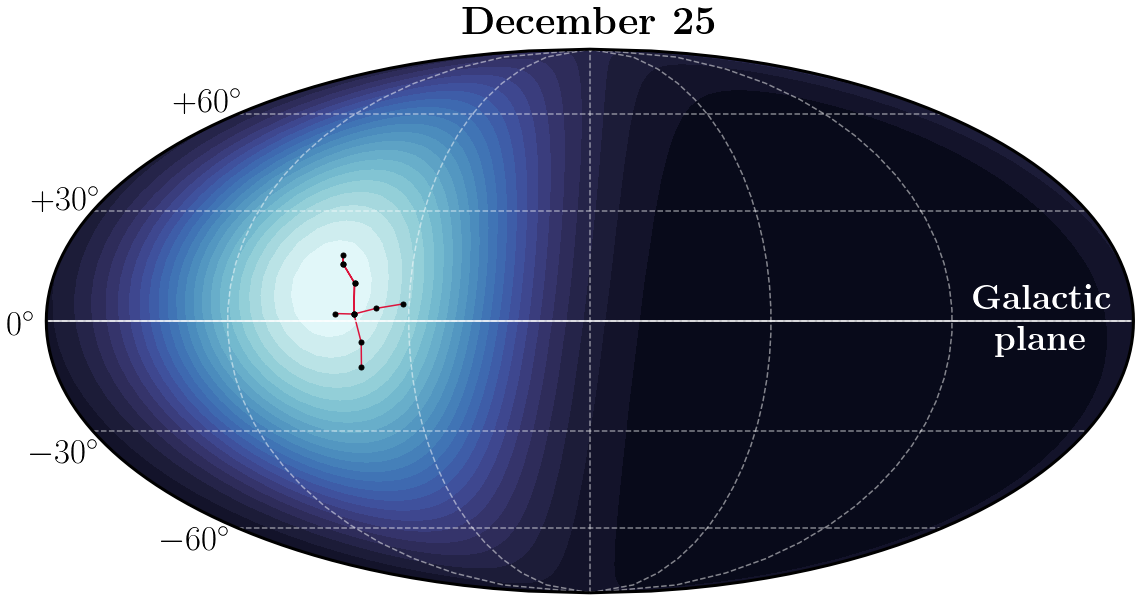

In [155]:
# Set up figure
fig, axarr = plt.subplots(1, 1,figsize=(20,10))
gs = gridspec.GridSpec(1, 1)
gs.update(wspace=0.1)

# Mollweide
ax = plt.subplot(gs[0],projection=ccrs.Mollweide())
xtx = array([0.17,0.05,-0.01,0.05,0.18])
ytx = array([0.1,0.26,0.49,0.72,0.9])
tx = array([r'$-60^\circ$',r'$-30^\circ$',r'$0^\circ$',r'$+30^\circ$',r'$+60^\circ$']) 
ax.plot(-cyg[:,0],cyg[:,1],'.',color='k',ms=10,transform=ccrs.PlateCarree())

frames = 50
interval = (365.0/(1.0*frames))

for i in range(0,frames):
    ti = i*interval
    t = Jan1 + ti
    imonth = arange(0,12)[datecumsum-ti>0][0]
    wmonth = Months[imonth]
    di = int(around(1+ti*(imonth==0)+(ti-datecumsum[imonth-1])*(imonth>0)))
    print(i,wmonth,di,i*interval)

    PH,TH,dR_wimp,dR_mapw,dR_mapn = GetMaps(t,20,80)
    cmax = 1.0
    cmin = 0.0

    ax.clear()
    gl = ax.gridlines(color=gridlinecolor,linewidth=1.5, linestyle='--',alpha=0.5)
    gl.ylocator = mticker.FixedLocator([-90,-60, -30, 0, 30, 60,90])
    ax.outline_patch.set_linewidth(3)

    for j in range(0,size(xtx)):
        plt.text(xtx[j],ytx[j],tx[j],transform=ax.transAxes,horizontalalignment='right',verticalalignment='center',fontsize=tfs)

    ax.plot(-cyg[0:4,0],cyg[0:4,1],'-',color='crimson',transform=ccrs.PlateCarree())
    ax.plot(-cyg[4:,0],cyg[4:,1],'-',color='crimson',transform=ccrs.PlateCarree())
    points = ax.plot(-cyg[:,0],cyg[:,1],'.',color='k',ms=10,transform=ccrs.PlateCarree())
    ax.text(127,3,r'{\bf Galactic}',color=gridlinecolor,transform=ccrs.PlateCarree(),fontsize=tfs)
    ax.text(135,-8,r'{\bf plane}',color=gridlinecolor,transform=ccrs.PlateCarree(),fontsize=tfs)
    ax.background_patch.set_facecolor('k')
    ax.contourf(rad2deg(PH), rad2deg(TH), dR_mapw,levels=linspace(0.0,1.0,25),transform=ccrs.PlateCarree(),cmap=cmocean.cm.ice,vmin=cmin,vmax=cmax)
    ax.set_title(r'{\bf '+wmonth+' '+str(di)+'}',fontsize=tfs+5,pad=15)
    line = ax.plot([-181,181],[0,0],'-',color=gridlinecolor,lw=1.5,transform=ccrs.PlateCarree())
    ax.plot([0,0],[-90,90],'.',color=gridlinecolor,transform=ccrs.PlateCarree())
    #plt.show()
    fig.savefig('../movies/Skymaps_WIMP/'+str(i)+'.png',bbox_inches='tight')
    

    

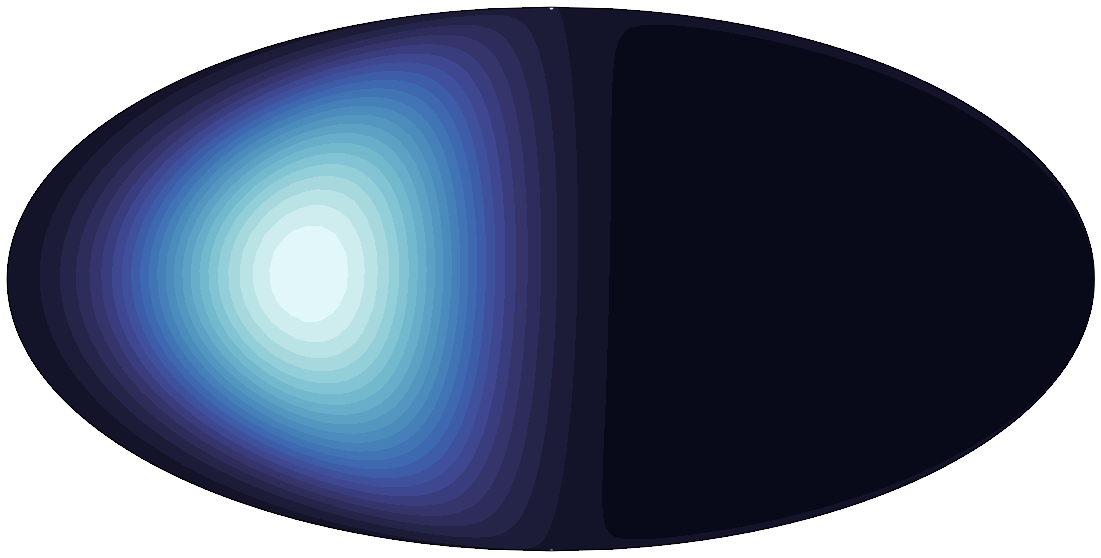

In [154]:
# Set up figure
fig, axarr = plt.subplots(1, 1,figsize=(20,10))
gs = gridspec.GridSpec(1, 1)
gs.update(wspace=0.1)


PH,TH,dR_wimp,dR_mapw,dR_mapn = GetMaps(t,20,80)
cmax = 1.0
cmin = 0.0
    
    
# Mollweide
ax = plt.subplot(gs[0],projection=ccrs.Mollweide())
ax.contourf(rad2deg(PH), rad2deg(TH), dR_mapw,levels=linspace(0.0,1.0,25),transform=ccrs.PlateCarree(),cmap=cmocean.cm.ice,vmin=cmin,vmax=cmax)





ax.plot([0,0],[-90,90],'.',color=gridlinecolor,transform=ccrs.PlateCarree())